`Walter Reade, Ashley Chow. (2024)`. Binary Classification with a Bank Churn Dataset . Kaggle. https://kaggle.com/competitions/playground-series-s4e1

**Goal** From the inference predict whether a customer continues with their account or closes it (e.g., churns)  
**search exercise is done on Google Colab**  please refer to executed script on [GitHub](https://github.com/jayc279/kaggle_notebooks/blob/main/DeepLearning-NN-bank-churn-hyperparameters_search.ipynb)

**Included two NN models for hyperparameter search**
1. Sequential
2. Functional

in function: **create_hyper_model** make changes in callback to pick which function you would like to use

In [1]:
import numpy as np
import pandas as pd
import math
import os
import gc
import re
import inspect

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
## Import train and test sets
train_dataset = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_dataset = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

In [3]:
# check datasets
print(train_dataset.shape, train_dataset.columns)

(165034, 14) Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [4]:
print(test_dataset.shape, test_dataset.columns)

(110023, 13) Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [5]:
train_dataset.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
train_dataset.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


## cleanup datasets
1. capture 'Exited' from train-dataset as 'true' label
2. capture 'id' from test_data set to create submission-file
3. drop columns - 'id', 'CustomerId', 'Surname' - from both datasets
4. convert columns - Tenure, Geography, Gender, NumOfProducts, HasCrCard, IsActiveMember - to categorical
5. scale numeric columns

In [8]:
# make copies so as not to reload if error during EDA
trainX = train_dataset.copy()
testX = test_dataset.copy()

trainY = trainX['Exited']
trainX = train_dataset.drop(['Exited'], axis=1)

In [9]:
# we wull have to convert Tenure, IsActiveMember, NumOfProducts, HasCrCard  to categorical
# drop id, CustomerId, Surname
# Geography, Gender already are objects
trainX.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

test_id = testX['id']
print(test_id[:10])

# drop id column from test_dataset
testX.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

0    165034
1    165035
2    165036
3    165037
4    165038
5    165039
6    165040
7    165041
8    165042
9    165043
Name: id, dtype: int64


In [10]:
trainX.Tenure = trainX.Tenure.astype('category')
trainX.Geography = trainX.Geography.astype('category')
trainX.Gender = trainX.Gender.astype('category')
trainX.NumOfProducts = trainX.NumOfProducts.astype('category')
trainX.HasCrCard      = trainX.HasCrCard.astype('category')
trainX.IsActiveMember = trainX.IsActiveMember.astype('category')

In [11]:
testX.Tenure = testX.Tenure.astype('category')
testX.Geography = testX.Geography.astype('category')
testX.Gender = testX.Gender.astype('category')
testX.NumOfProducts = testX.NumOfProducts.astype('category')
testX.HasCrCard      = testX.HasCrCard.astype('category')
testX.IsActiveMember = testX.IsActiveMember.astype('category')

In [12]:
trainX.info(), testX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   CreditScore      165034 non-null  int64   
 1   Geography        165034 non-null  category
 2   Gender           165034 non-null  category
 3   Age              165034 non-null  float64 
 4   Tenure           165034 non-null  category
 5   Balance          165034 non-null  float64 
 6   NumOfProducts    165034 non-null  category
 7   HasCrCard        165034 non-null  category
 8   IsActiveMember   165034 non-null  category
 9   EstimatedSalary  165034 non-null  float64 
dtypes: category(6), float64(3), int64(1)
memory usage: 6.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   CreditScore      110023 non-null  int6

(None, None)

In [13]:
trainX.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


In [14]:
testX.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## Convert categorical and numeric columns to continue with EDA
1. to one-hot
2. numerical columns to have mean of '0' and variance of '1'

In [15]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
# https://pieriantraining.com/complete-guide-to-feature-scaling-in-scikit-learn/
# https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from math import floor
score_acc = make_scorer(accuracy_score)

In [16]:
# this code bit from 
# https://stephenallwright.com/scale-columns-traing-score/
columns_list = list(trainX.describe(exclude='category'))
print(columns_list)
def scale_columns(df, columns, scalers):
    if scalers is None:
        scalers = {}
        for col in columns:
            scaler = MinMaxScaler().fit(df[[col]])
            df[col] = scaler.transform(df[[col]])
            scalers[col] = scaler
    else:
        for col in columns:
            scaler = scalers.get(col)
            df[col] = scaler.transform(df[[col]])
    return df, scalers

trainX,scalers = scale_columns(trainX,columns=columns_list,scalers=None)
testX,scalers = scale_columns(testX,columns=columns_list,scalers=scalers)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


In [17]:
trainX.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.636,France,Male,0.202703,3,0.000000,2,1.0,0.0,0.907279
1,0.554,France,Male,0.202703,1,0.000000,2,1.0,1.0,0.247483
2,0.656,France,Male,0.297297,10,0.000000,2,1.0,0.0,0.924364
3,0.462,France,Male,0.216216,2,0.593398,1,1.0,1.0,0.422787
4,0.732,Spain,Male,0.202703,5,0.000000,2,1.0,1.0,0.075293


In [18]:
testX.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.472,France,Female,0.067568,2,0.000000,2,0.0,1.0,0.804903
1,0.666,France,Female,0.378378,2,0.000000,1,1.0,0.0,0.362723
2,0.612,France,Female,0.216216,7,0.000000,2,1.0,0.0,0.694419
3,0.662,France,Male,0.243243,8,0.000000,1,1.0,0.0,0.569654
4,0.804,Germany,Male,0.270270,10,0.483318,1,1.0,0.0,0.697164


In [19]:
trainX.shape, testX.shape

((165034, 10), (110023, 10))

In [20]:
testX = pd.get_dummies(testX)
trainX = pd.get_dummies(trainX)

In [21]:
trainX.shape, testX.shape

((165034, 28), (110023, 28))

In [22]:
# convert True -> 1 and False to 0
trainX = trainX.replace({True: 1, False: 0})
testX = testX.replace({True: 1, False: 0})

In [23]:
trainX.head()

,CreditScore,Age,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Tenure_0,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
0,0.636,0.202703,0.000000,0.907279,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
1,0.554,0.202703,0.000000,0.247483,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2,0.656,0.297297,0.000000,0.924364,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0
3,0.462,0.216216,0.593398,0.422787,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
4,0.732,0.202703,0.000000,0.075293,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1


In [24]:
testX.head()

,CreditScore,Age,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Tenure_0,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
0,0.472,0.067568,0.000000,0.804903,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,0.666,0.378378,0.000000,0.362723,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
2,0.612,0.216216,0.000000,0.694419,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0
3,0.662,0.243243,0.000000,0.569654,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
4,0.804,0.270270,0.483318,0.697164,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0


In [25]:
# one final check to verify dataset is clean
trainX.isnull().sum().sum(), testX.isnull().sum().sum()

(0, 0)

In [26]:
# split trainX into train and validation sets
train_X, val_X, train_y, val_y = train_test_split(trainX, trainY, test_size=0.3, shuffle=True, random_state=42)

In [27]:
print(train_X.shape, val_X.shape, train_y.shape, val_y.shape, testX.shape)

(115523, 28) (49511, 28) (115523,) (49511,) (110023, 28)


In [28]:
# Create Neural Network to train dataset and predict test data
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2, L1L2
import tensorflow.keras as keras

2024-02-02 03:24:41.474671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 03:24:41.474800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 03:24:41.654662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
!pip install scikeras

In [30]:
# import KerasClassifier
# from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow.keras as keras
from keras.constraints import MaxNorm
from keras.initializers import glorot_uniform, he_uniform, glorot_normal, he_normal
# from keras.initializers import uniform, normal, zero
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU, ReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [31]:
# number in optimizers_list 8
optimizers_list = ['SGD', 'RMSprop', 'Adam', 'Adagrad',
                   'Adadelta', 'Adamax', 'Nadam', 'Ftrl','SGD']

# number in activations_list 5
activations_list = ['relu', 'tanh', 'selu', 
                    'elu', 'exponential', 'relu']

# number in init_mode_list 8
init_mode_list = ['uniform', 'lecun_uniform', 'normal', 
                  'zero', 'glorot_normal', 'glorot_uniform', 
                  'he_normal', 'he_uniform', 'uniform']

## for this run wil use hyperparameters from GRID search done on Google Colab

In [32]:
num_outputs = 1
trainX_model = train_X
trainy_model = train_y
valX_model = val_X
valy_model = val_y
testX_model = testX

num_inputs = trainX_model.shape[1]
num_samples = trainX_model.shape[0]
use_scale_ratio = 1.0     # used in intermediate layers

# create dictionary to store hyper-parameters
hyper_params = dict()

print(
    f"{'use_scale_ratio:':<15}{use_scale_ratio:>10}",
    f"{'num_inputs:':<15}{num_inputs:>10}",
    f"{'num_outputs:':<15}{num_outputs:>10}",
    sep='\n'
)

def_batch = 32
def_epoch = 100
def_num_layers = 3
def_dropout = 0.2
def_neurons = 128

print(
    f"{'def_neurons:':<15}{def_neurons:>10}",
    f"{'def_num_layers:':<15}{def_num_layers:>10}",
    f"{'def_batch:':<15}{def_batch:>10}",
    f"{'def_epoch:':<15}{def_epoch:>10}",
    f"{'def_dropout:':<15}{def_dropout:>10}",
    sep='\n'
)

use_scale_ratio:       1.0
num_inputs:            28
num_outputs:            1
def_neurons:          128
def_num_layers:         3
def_batch:             32
def_epoch:            100
def_dropout:          0.2


In [33]:
# default values to setup a Keras model
hyper_params['learning_rate']     = 0.001
hyper_params['momentum']          = 0.5 
hyper_params['init_mode']         = 'he_uniform'
hyper_params['activation']        = 'relu'
hyper_params['dropout']           = def_dropout
hyper_params['weight_constraint'] = 4.0                 
hyper_params['neurons']           = def_neurons
hyper_params['optimizer']         = 'SGD'
hyper_params['epochs']            = def_epoch
hyper_params['batch_size']        = def_batch
hyper_params['num_hidden_layers'] = def_num_layers
hyper_params['l2_rate']           = 1e-4

In [34]:
trainX_model.head()

,CreditScore,Age,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Tenure_0,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
76047,0.348,0.364865,0.000000,0.664315,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0
57212,0.538,0.324324,0.376619,0.971400,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
159972,0.916,0.202703,0.412585,0.569535,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0
7950,0.384,0.081081,0.000000,0.652216,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
65073,0.472,0.324324,0.434097,0.614628,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0


In [35]:
valX_model.head()

,CreditScore,Age,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Tenure_0,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
33042,0.896,0.175676,0.406842,0.397867,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
36330,0.558,0.108108,0.000000,0.190914,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0
59446,0.430,0.283784,0.459004,0.345238,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0
92278,0.606,0.500000,0.280049,0.311710,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
146750,0.414,0.175676,0.424859,0.456515,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0


## function to create Sequential and Functional Neural Network Models

In [36]:
def create_hyper_model(lr=hyper_params['learning_rate'],
                       momentum=hyper_params['momentum'],
                       init_mode=hyper_params['init_mode'],
                       activation=hyper_params['activation'],
                       dropout=hyper_params['dropout'],
                       weight_constraint=hyper_params['weight_constraint'],
                       neurons=hyper_params['neurons'],
                       optimizer=hyper_params['optimizer'],
                       num_hidden_layers=hyper_params['num_hidden_layers'],
                       epochs=hyper_params['epochs'],
                       batch_size=hyper_params['batch_size'],
                       create_model=False,
                       l2=hyper_params['l2_rate'],
                      ):
    
    # clear model session and recreate - 
    # according to Keras docs works for a functional model
    keras.backend.clear_session()  
    dense_dict = inspect.signature(Dense)
    dropout_dict = inspect.signature(Dropout)
    batch_norm_dict = inspect.signature(BatchNormalization)

    ###################################################
    # get defaults for hyper-search parameter values
    ###################################################
    epochs = 70 if epochs is None else round(epochs)
    batch_size = 32 if batch_size is None else round(batch_size)

    # number in init_mode_list 8
    if type(init_mode) is not str:
        init_mode = 'glorot_normal' if init_mode is None else init_mode_list[round(init_mode)]

    # number in activations_list 5
    if type(activation) is not str:
        activation = 'relu' if activation is None else activations_list[round(activation)]
    
    # print(f'neurons:{neurons} - num_hidden_layers:{num_hidden_layers}')
    weight_constraint = 4.0 if weight_constraint is None else weight_constraint
    dropout = 0.2 if dropout is None else dropout
    l2 = 1e-4 if l2 is None else l2
    lr = 0.001 if lr is None else lr
    momentum = 0.0 if momentum is None else momentum
    num_hidden_layers = 2 if num_hidden_layers is None else num_hidden_layers
    neurons = 1024 if neurons is None else neurons
        
    # number in optimizers_list 8
    if type(optimizer) is not str:
        optimizer = 'SGD' if optimizer is None else optimizers_list[round(optimizer)]

    # print(f'neurons:{neurons} - num_hidden_layers:{num_hidden_layers}')
    neurons = round(neurons)
    num_hidden_layers = round(num_hidden_layers)
    # print(f'neurons:{neurons} - num_hidden_layers:{num_hidden_layers}')

    ###################################################
    # create model
    ###################################################
    def build_seq_neural():
        
        model = Sequential()
        model.add(Dense(neurons, input_shape=(num_inputs,),    
                      kernel_initializer=init_mode, 
                      activation=activation,
                      kernel_constraint=MaxNorm(weight_constraint),
                      kernel_regularizer=L2(l2),
                     ))
        
        # BatchNormalization only used in CONV Neural Nets
        # if momentum > 0.5:
        #    model.add(BatchNormalization(momentum=momentum))
        use_scale_ratio = 1.0 # This var must be defined in 'build_neural'
        if dropout > 0.1:  model.add(Dropout(dropout))                       # Dropout

        if num_hidden_layers > 0:                          # activated only if # > 0
            # print(f'use_scale_ratio: {use_scale_ratio}')'
            for i in range(0, math.ceil(num_hidden_layers -1) ):  
                use_scale_ratio = use_scale_ratio / num_hidden_layers
                model.add(Dense(round(math.ceil(neurons * use_scale_ratio)),
                            kernel_initializer=init_mode, 
                            activation=activation,
                            kernel_constraint=MaxNorm(weight_constraint),
                            kernel_regularizer=L2(l2),
                      ))

            
        # if num_hidden_layers > 1:                         
        # activated irrespective of hidden layer
        model.add(Dense(round(math.ceil(neurons * use_scale_ratio * dropout )), 
                      kernel_initializer=init_mode,
                      activation=activation,
                      kernel_regularizer=L2(l2),
                      kernel_constraint=MaxNorm(weight_constraint)))
        if dropout < 0.2: model.add(Dropout(dropout))                    # Dropout
        
        model.add(Dense(num_outputs, kernel_initializer=init_mode, activation='sigmoid'))
      ###################################################
      
        # Compile model
        opt=keras.optimizers.get(optimizer)   # opt.__dir__ to know what can be set
        opt_list = ['SGD','RMSprop']
      
        # if optimizer is one of 'SGD' -or- 'RMSprop'
        if optimizer in opt_list:
            opt.momentum=momentum
          
        opt.learning_rate=lr
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      
        return model
    ###################################################
    def build_neural():
        
        input = Input(shape=(num_inputs,))
        drop_out = Dropout(dropout)(input)                       # Dropout
        lay1 = Dense(neurons, kernel_initializer=init_mode, 
                   activation=activation,
                   kernel_constraint=MaxNorm(weight_constraint),
                   kernel_regularizer=L2(l2))(drop_out)

        # BatchNormalization only used in CONV Neural Nets
        # if momentum > 0.5:
        #    model.add(BatchNormalization(momentum=momentum))
        use_scale_ratio = 0.75 # This var must be defined in 'build_neural'
      
        # if dropout > 0.1:  model.add(Dropout(dropout))                       # Dropout\
        res_lyr = lay1
        prev_lyr = None
        if num_hidden_layers > 0:
            # activated only if # > 0
            # print(f'use_scale_ratio: {use_scale_ratio}')'
            for i in range(0, round(math.ceil(num_hidden_layers -1))):
                use_scale_ratio = use_scale_ratio / num_hidden_layers
                prev_lyr = lay1 if prev_lyr is None else lays
                lays = 'lyr_'+str(i)
                lays = Dense(round(math.ceil(neurons * use_scale_ratio)),
                             kernel_initializer=init_mode, 
                             activation=activation,
                             kernel_constraint=MaxNorm(weight_constraint),
                             kernel_regularizer=L2(l2))(prev_lyr)

        if prev_lyr is None: prev_lyr = lay1
        # Dense(round(math.ceil(neurons * use_scale_ratio * dropout )),
        final_fc = Dense(round(math.ceil(neurons * use_scale_ratio )), 
                         kernel_initializer=init_mode, activation=activation, 
                         kernel_regularizer=L2(l2), 
                         kernel_constraint=MaxNorm(weight_constraint))(prev_lyr)

        # if num_hidden_layers > 1:                         # activated irrespective of hidden layer
        if dropout > 0.2:
            final_fc = Dropout(dropout)(final_fc)                    # Dropout
      
        output = Dense(num_outputs, kernel_initializer=init_mode, activation='sigmoid')(final_fc)
        model = Model(inputs=input, outputs=output)
      ###################################################   
      
        # Compile model
        opt=keras.optimizers.get(optimizer)   # opt.__dir__ to know what can be set
        opt_list = ['SGD','RMSprop']
      
        # if optimizer is one of 'SGD' -or- 'RMSprop'
        if optimizer in opt_list:
            opt.momentum=momentum
          
        opt.learning_rate=lr
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      
        return model
    ###################################################
  
    if create_model:
        return build_neural()
      
    else:
        es = EarlyStopping(
            monitor='accuracy', 
            mode='max', 
            verbose=0, 
            patience=5,
          )
      
        # Functional: build_neural
        # Sequential: build_seq_neural
        nn = KerasClassifier(
            build_fn=build_neural,    # change which model you want to build
            epochs=epochs, 
            batch_size=batch_size,
            verbose=0,
          )
      
        kfold = StratifiedKFold(
            n_splits=5, 
            shuffle=True,
            random_state=125,
          )
      
        score = cross_val_score(
            nn, 
            trainX_model, 
            trainy_model, 
            scoring=score_acc, 
            cv=kfold, 
            fit_params = {'callbacks':[es]}
          ).mean()
  
    return score        


## hypertuning using Bayesian Optimization Grid Search

In [37]:
import tensorflow as tf
seed = 7
tf.random.set_seed(seed)

batch_end = 512 
batch_size=(32, batch_end)
epochs = (10,50)

max_num_layers = 3           # No formula, always change manually - 3 works
num_hidden_layers = (0, max_num_layers)

alpha = 2.0 * max_num_layers # alpha - some value btw 2 -> 10     - 7.0 works
min_check = round(num_inputs + num_outputs)
max_check = round(num_samples * alpha)
max_layers = 256 if max_check > 256 else max_check
neurons = (min_check, max_layers)

lr = (0.001, 1.0)                           # learning_rate
momentum = (0.0, 0.99)                      # momentum for optimizers - SGD, RMSprop
weight_constraint = (1.0, 6.0)              # layers
dropout = (0.2, 0.7)                        # dropout ratio for Dropout layer

# normalization - Batch    - use this setting only for BatchNorm layer
# normalization = (0,1),

# number in optimizers_list 8
optimizer = (0, 8)

# number in init_mode_list 8
init_mode = (0, 8)

# number in activations_list 5
activation = (0, 4)

# keras.regularizers.l1(0.01)   # sum of absolute weights
# keras.regularizers.l2(0.01)   # sum of the suared weights
# keras.regularizers.l1_l2(l1=0.01, l2=0.01)  # sum of absolute and squared weights
l2 = (1e-4, 0.1)

# from keras.regularizers import l2
# model.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# create param_grid dictionary
param_grid = dict(batch_size = batch_size,
                  optimizer = optimizer,
                  lr = lr,
                  l2 = l2,
                  neurons = neurons,
                  num_hidden_layers = num_hidden_layers,
                  momentum = momentum,
                  init_mode = init_mode,
                  activation = activation,
                  weight_constraint = weight_constraint,
                  dropout = dropout,
                  epochs = epochs,
                 )


In [38]:
params_df = pd.DataFrame.from_dict(data=param_grid)
print(params_df.T)

# Run Bayeisian Optimization
nn_bo = BayesianOptimization(create_hyper_model, param_grid, random_state=111)

                         0       1
batch_size         32.0000  512.00
optimizer           0.0000    8.00
lr                  0.0010    1.00
l2                  0.0001    0.10
neurons            29.0000  256.00
num_hidden_layers   0.0000    3.00
momentum            0.0000    0.99
init_mode           0.0000    8.00
activation          0.0000    4.00
weight_constraint   1.0000    6.00
dropout             0.2000    0.70
epochs             10.0000   50.00


## hyperparameter search is executed only 
if **execute_bayes_opt** is True  
    - please use Google Colab or AWS EC2 for hyperparameter search

In [39]:
execute_bayes_opt = False     # change to True to execute search

if execute_bayes_opt:
    ## NOT EXECUTING ON KAGGLE - pls try on Google Colab or AWD EC2 ##
    ## maximize hyper-parameters
    ##  nn_bo.maximize(init_points=10, n_iter=3)
    #
    nn_bo.maximize(init_points=5, n_iter=1)

In [40]:
if execute_bayes_opt:
    # best hyper-parameters
    params_nn_ = nn_bo.max['params']

    params_df = pd.DataFrame.from_dict(params_nn_, orient='index')
    print(params_df)

    print(params_nn_.keys())

    # define activationL
    params_nn_['activation'] = activations_list[round(params_nn_['activation'])]
    params_nn_['init_mode'] = init_mode_list[round(params_nn_['init_mode'])]
    params_nn_['optimizer'] = optimizers_list[round(params_nn_['optimizer'])]
    print(params_nn_)

    for key,value in params_nn_.items():
        hyper_params[key] = value

    # list all hyper-parameters for this run
    for key in hyper_params.keys():
        print(f'key: {key:20s} value: {hyper_params[key]}')


## callbacks

In [41]:
save_best_model = keras.callbacks.ModelCheckpoint(filepath='bank_churn.keras',
                                  monitor='val_loss',
                                  save_best_only=True,
)

# early stopping call back on 'val_loss'
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # what to monitor 
                         min_delta=0.02,       # change to monitor
                         patience= 10, # round(best_epoch_num/10), # num of epochs to wait before breaking out
                         mode='max',          # here 'min' stop decreasing
                         verbose=1,           # verbose=0 don't print output
                         restore_best_weights=True,   # whether to restore model weights
                        )

In [42]:
# https://www.tensorflow.org/guide/keras/writing_your_own_callbacks
# https://keras.io/guides/writing_your_own_callbacks/
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

    Arguments:
        schedule: a function that takes an epoch index
            (integer, indexed from 0) and current learning rate
            as inputs and returns a new learning rate as output (float).
    """

    def __init__(self, schedule):
        super().__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (3, 0.05),
    (6, 0.01),
    (9, 0.005),
    (12, 0.001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

## create final model with hyperparameters 

In [43]:
# final model parameters based on grid search - accuracy is not good since the dataset needs cleaning
# values from Google Colab run
hyper_params['learning_rate'] = 0.001
hyper_params['momentum'] = 0.6621259179814157
hyper_params['init_mode'] = 'glorot_uniform'
hyper_params['activation'] = 'selu'
hyper_params['dropout'] = 0.28967239193301675
hyper_params['weight_constraint'] = 5.816334364872265
hyper_params['neurons'] = 129.16787623724508
hyper_params['optimizer'] = 'Adadelta'
hyper_params['epochs'] = 15.984528629437222
hyper_params['batch_size'] = 117.74038879385675
hyper_params['num_hidden_layers'] = 1.785676351323205
hyper_params['l2_rate'] = 0.0001
hyper_params['l2'] = 0.04695395420696539
hyper_params['lr'] = 0.7684796829725257


In [44]:
# create model with best parameters from BayesOptimizer
model = create_hyper_model(lr=hyper_params['lr'],
                           momentum=hyper_params['momentum'],
                           init_mode=hyper_params['init_mode'],
                           activation=hyper_params['activation'],
                           dropout=hyper_params['dropout'],
                           weight_constraint=hyper_params['weight_constraint'],
                           neurons=hyper_params['neurons'],
                           optimizer=hyper_params['optimizer'],
                           num_hidden_layers=hyper_params['num_hidden_layers'],
                           l2=hyper_params['l2'],
                           epochs=hyper_params['epochs'],
                           batch_size=hyper_params['batch_size'],                           
                           create_model=True,
                          )
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dropout (Dropout)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 129)               3741      
                                                                 
 dense_2 (Dense)             (None, 49)                6370      
                                                                 
 dropout_1 (Dropout)         (None, 49)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 50        
                                                                 
Total params: 10161 (39.69 KB)
Trainable params: 10161 (39.69

In [45]:
num_epochs = hyper_params['epochs']
num_batch_size = hyper_params['batch_size']
print('number of epochs: ', num_epochs,'batch_size: ',  num_batch_size)
# cb = TimingCallback()
# callbacks_list = [early_stop, CustomLearningRateScheduler(lr_schedule), save_best_model]
callbacks_list = [early_stop, save_best_model]
# callbacks_list = [save_best_model]

history = model.fit(trainX_model, trainy_model,
                    epochs=round(num_epochs),
                    batch_size=round(num_batch_size),
                    validation_data=(valX_model, valy_model),
                    callbacks=callbacks_list,
                    verbose=1,
                   )


number of epochs:  15.984528629437222 batch_size:  117.74038879385675
Epoch 1/16
980/980 [==============================] - 5s 4ms/step - loss: 0.8290 - accuracy: 0.8012 - val_loss: 0.4260 - val_accuracy: 0.8080
Epoch 2/16
980/980 [==============================] - 3s 3ms/step - loss: 0.4460 - accuracy: 0.8079 - val_loss: 0.4226 - val_accuracy: 0.8343
Epoch 3/16
980/980 [==============================] - 3s 3ms/step - loss: 0.4410 - accuracy: 0.8106 - val_loss: 0.4852 - val_accuracy: 0.7908
Epoch 4/16
980/980 [==============================] - 3s 3ms/step - loss: 0.4398 - accuracy: 0.8118 - val_loss: 0.4232 - val_accuracy: 0.7992
Epoch 5/16
980/980 [==============================] - 3s 3ms/step - loss: 0.4348 - accuracy: 0.8141 - val_loss: 0.3980 - val_accuracy: 0.8315
Epoch 6/16
980/980 [==============================] - 3s 3ms/step - loss: 0.4333 - accuracy: 0.8127 - val_loss: 0.4179 - val_accuracy: 0.8038
Epoch 7/16
980/980 [==============================] - 3s 3ms/step - loss: 0.43

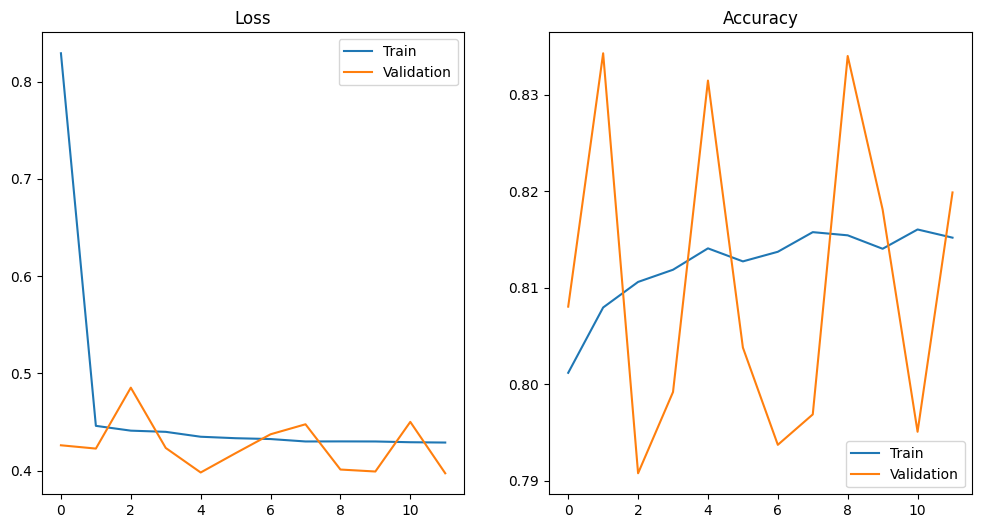

In [46]:
# plot loss
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.legend(['Train', 'Validation'])

# plot accuracy
plt.subplot(122)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend(['Train', 'Validation'])

## Evaluate and predict Validation set

1548/1548 [==============================] - 2s 2ms/step - loss: 0.4226 - accuracy: 0.8343
Val accuracy:  0.834
1548/1548 [==============================] - 2s 1ms/step
[0 1] [0 1] 0 1
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     39133
           1       0.67      0.42      0.52     10378

    accuracy                           0.83     49511
   macro avg       0.76      0.68      0.71     49511
weighted avg       0.82      0.83      0.82     49511



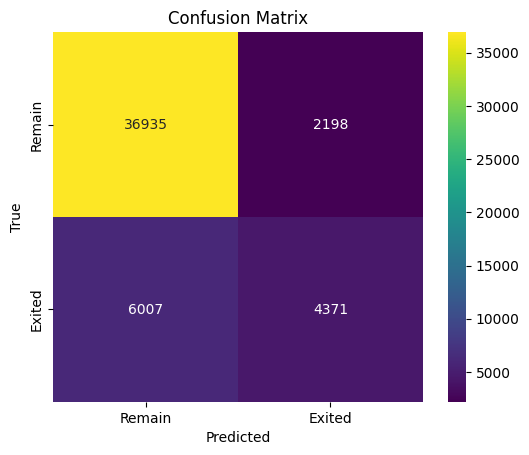

In [47]:
score = model.evaluate(valX_model, valy_model)
print('Val accuracy: ', round(score[1],3))

val_predict = model.predict(valX_model)
yhat = [1 if predict > 0.5 else 0 for predict in val_predict]
print(trainy_model.unique(), valy_model.unique(), min(yhat), max(yhat))

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(valy_model, yhat))

labels=['Remain', 'Exited']
sns.heatmap(confusion_matrix(valy_model, yhat), annot=True, cmap='viridis', fmt='d', square=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Create predictions on Test set and prepare for submission

In [48]:
test_predictions = model.predict(testX_model)
test_model_data = pd.DataFrame()
test_model_data['id'] = test_id
test_model_data['Exited'] = [1 if predict > 0.5 else 0 for predict in test_predictions]
test_model_data.to_csv('bank_churn_submission.csv', index = False)

3439/3439 [==============================] - 5s 1ms/step


In [49]:
test_predictions.max(), test_predictions.min(), test_predictions.mean()
len(test_model_data[test_model_data['Exited'] == 1])

14724

In [50]:
# !head -10 /kaggle/working/bank_churn_submission.csv